In [1]:
from __future__ import division, print_function
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd

In [2]:
import seaborn as sns
sns.set_style("white")
np.random.seed(10)
matplotlib.rc("font", size=30)

# Example of using two distance + thresholds in one ABC sampling run

In [3]:
samples_size = 1000
mean = 2
sigma = 1
data = np.random.normal(mean, sigma, samples_size)

<IPython.core.display.Javascript object>


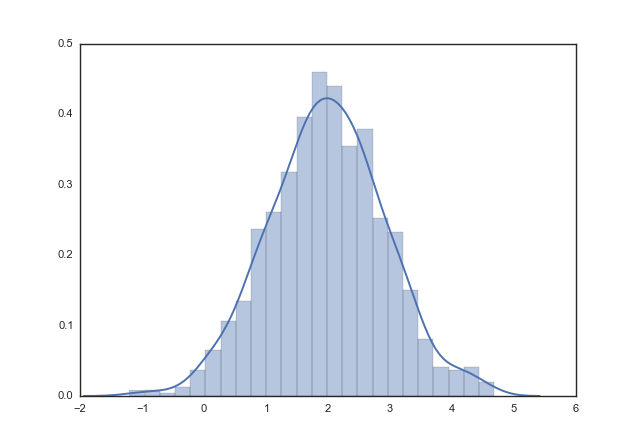

In [4]:
f,ax = plt.subplots()
sns.distplot(data)

In [5]:
def create_new_sample(theta):
    mu,sigma = theta
    if sigma<=0:
        sigma=10
    return np.random.normal(mu, sigma, samples_size)


### Distance measure compares mean + variance

In [6]:
def dist_measure(x, y):
    return [np.abs(np.mean(x, axis=0) - np.mean(y, axis=0)),
            np.abs(np.var(x, axis=0) - np.var(y, axis=0))]


In [7]:
distances = [dist_measure(data, create_new_sample((mean, sigma))) for _ in range(1000)]

In [8]:
dist_labels = ["mean", "var"]

<IPython.core.display.Javascript object>


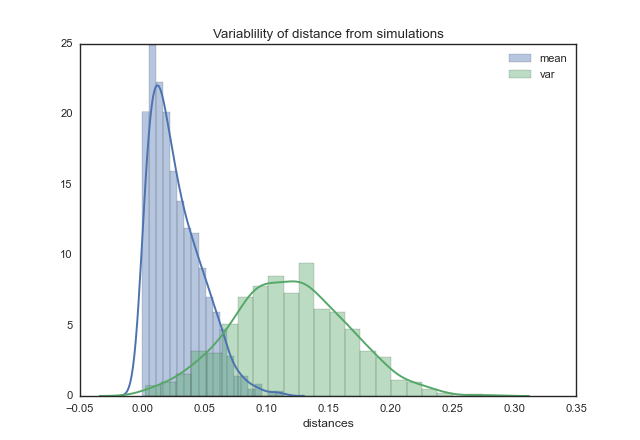

In [9]:
f, ax = plt.subplots()
sns.distplot(np.asarray(distances)[:, 0], axlabel="distances", label=dist_labels[0])
sns.distplot(np.asarray(distances)[:, 1], axlabel="distances", label=dist_labels[1])
plt.title("Variablility of distance from simulations")
plt.legend()

In [10]:
import abcpmc

In [11]:
prior = abcpmc.GaussianPrior(mu=[2.5, 1.5], sigma=np.eye(2) * 0.5)

In [12]:
alpha = 85
T = 100
eps_start = [1.0, 1.0]


In [13]:
sampler = abcpmc.Sampler(N=1000, Y=data, postfn=create_new_sample, dist=dist_measure, threads=7)

In [14]:
def launch():
    eps = abcpmc.ConstEps(T, eps_start)

    pools = []
    for pool in sampler.sample(prior, eps):
        eps_str = ", ".join(["{0:>.4f}".format(e) for e in pool.eps])
        print("T: {0}, eps: [{1}], ratio: {2:>.4f}".format(pool.t, eps_str, pool.ratio))

        for i, (mean, std) in enumerate(zip(*abcpmc.weighted_avg_and_std(pool.thetas, pool.ws, axis=0))):
            print(u"    theta[{0}]: {1:>.4f} \u00B1 {2:>.4f}".format(i, mean,std))

        eps.eps = np.percentile(pool.dists, alpha, axis=0) # reduce eps value
        pools.append(pool)
        if pool.ratio <0.2:
            break
    sampler.close()
    return pools


In [15]:
import time
t0 = time.time()
pools = launch()
print("took", (time.time() - t0))

T: 0, eps: [1.0000, 1.0000], ratio: 0.3049
    theta[0]: 2.2497 ± 0.4733
    theta[1]: 0.9012 ± 0.3332
T: 1, eps: [0.8020, 0.8103], ratio: 0.4019
    theta[0]: 2.1517 ± 0.4030
    theta[1]: 0.8991 ± 0.2833
T: 2, eps: [0.6595, 0.7113], ratio: 0.3817
    theta[0]: 2.0938 ± 0.3426
    theta[1]: 0.9183 ± 0.2422
T: 3, eps: [0.5378, 0.6029], ratio: 0.3592
    theta[0]: 2.0680 ± 0.2988
    theta[1]: 0.9175 ± 0.1944
T: 4, eps: [0.4546, 0.5084], ratio: 0.3614
    theta[0]: 2.0588 ± 0.2512
    theta[1]: 0.9293 ± 0.1609
T: 5, eps: [0.3746, 0.4250], ratio: 0.3495
    theta[0]: 2.0315 ± 0.2123
    theta[1]: 0.9350 ± 0.1359
T: 6, eps: [0.3074, 0.3494], ratio: 0.3378
    theta[0]: 2.0119 ± 0.1761
    theta[1]: 0.9304 ± 0.1102
T: 7, eps: [0.2495, 0.2929], ratio: 0.3358
    theta[0]: 2.0059 ± 0.1458
    theta[1]: 0.9321 ± 0.0948
T: 8, eps: [0.2015, 0.2454], ratio: 0.3129
    theta[0]: 2.0033 ± 0.1178
    theta[1]: 0.9349 ± 0.0777
T: 9, eps: [0.1691, 0.2000], ratio: 0.3355
    theta[0]: 1.9926 ± 0.0988


<IPython.core.display.Javascript object>


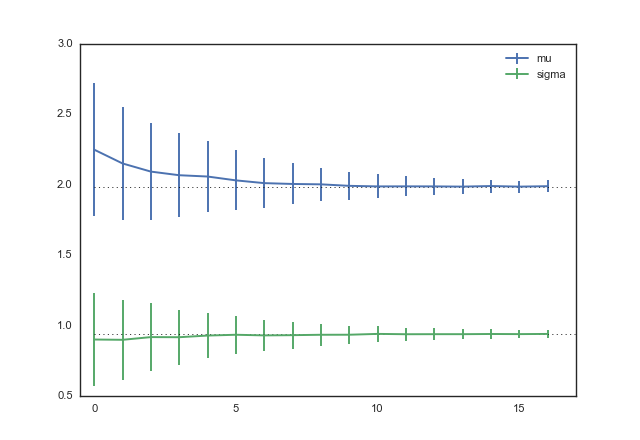

In [16]:
T = len(pools)
fig, ax = plt.subplots()
lables =["mu", "sigma"]
for i in range(2):
    moments = np.array([abcpmc.weighted_avg_and_std(pool.thetas[:,i], pool.ws, axis=0) for pool in pools])
    ax.errorbar(range(T), moments[:, 0], moments[:, 1], label=lables[i])
ax.hlines(np.mean(data), 0, T, linestyle="dotted", linewidth=0.7)
ax.hlines(np.std(data), 0, T, linestyle="dotted", linewidth=0.7)
ax.legend()
_ = ax.set_xlim([-.5, T])

<IPython.core.display.Javascript object>


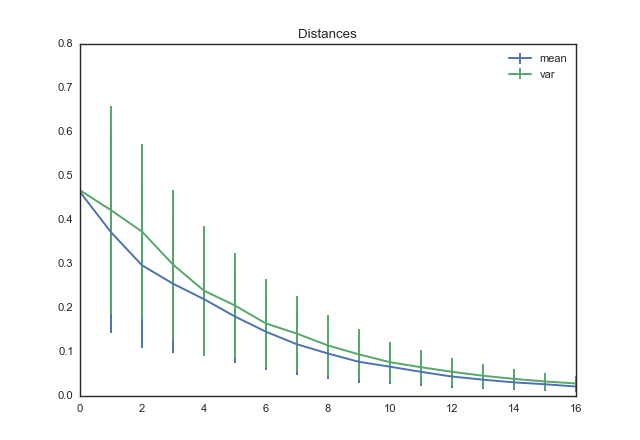

In [17]:
distances = np.array([pool.dists for pool in pools])
fig, ax = plt.subplots()
ax.errorbar(np.arange(len(distances)), np.mean(distances, axis=1)[:, 0], np.std(distances, axis=1)[:, 0], label=dist_labels[0])
ax.errorbar(np.arange(len(distances)), np.mean(distances, axis=1)[:, 1], np.std(distances, axis=1)[:, 1], label=dist_labels[1])
ax.legend()
ax.set_title("Distances")

<IPython.core.display.Javascript object>


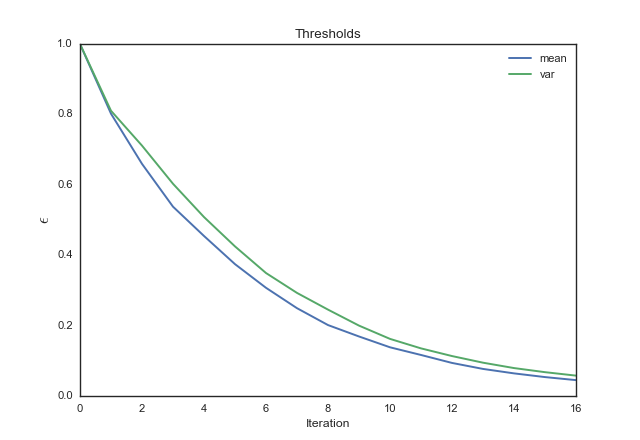

In [18]:
fig,ax = plt.subplots()
eps_values = np.array([pool.eps for pool in pools])
ax.plot(eps_values[:, 0], label=dist_labels[0])
ax.plot(eps_values[:, 1], label=dist_labels[1])
ax.set_xlabel("Iteration")
ax.set_ylabel(r"$\epsilon$", fontsize=15)
ax.legend(loc="best")
ax.set_title("Thresholds")

<IPython.core.display.Javascript object>


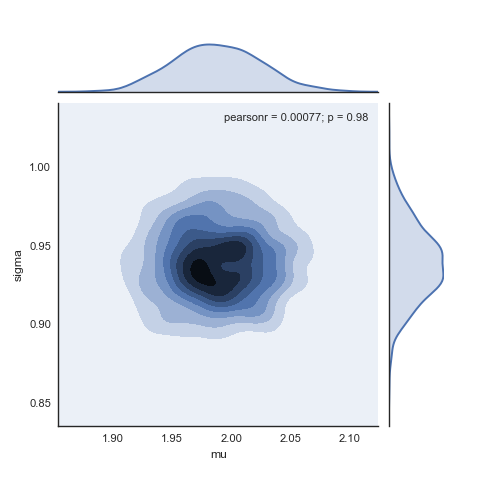

In [19]:
jg = sns.jointplot(pools[-1].thetas[:, 0], 
              pools[-1].thetas[:, 1], 
              kind="kde", 
             )
jg.ax_joint.set_xlabel(lables[0])
jg.ax_joint.set_ylabel(lables[1])